In [1]:
import numpy as np
from typing import List
import os
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Subset
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix
# from lib_FrogsCNN import *
n_epochs = 100
batch_size_train = 30
learning_rate = 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False

In [2]:
class CustomTensorDataset(torch.utils.data.TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

In [3]:
class CV_index:
    def __init__(self,Xidx,n_fold,setseed):
        Xidx=np.reshape(Xidx,(-1,1))
        self.go_through_idx=[]
        self.size_each_iter=[]
        from sklearn.model_selection import KFold 
        kf=KFold(n_splits=n_fold,shuffle=True,random_state=setseed)
        for _, test_index in kf.split(Xidx):
            self.go_through_idx=np.concatenate((self.go_through_idx,test_index),axis=0)
            self.size_each_iter.append(len(test_index))
        self.size_each_iter=np.array(self.size_each_iter)
        self.index_iter=self.size_each_iter.cumsum()
        self.index_iter=np.insert(self.index_iter,0,0)

In [29]:
##2 mappings we have:
### labels created by the image folder dataset, which has clades other than 4,5,8,12, to 0-9: train_dataset.class_to_idx
### labels created by the image folder dataset, which only has 4,5,8,12, to 0-3: dict_CV_clades2trainidx

In [4]:
class CustomTensorDataset(torch.utils.data.TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform
def dataloader_Frogs_CV(fold_idx = 0, batch_size_train = 15, batch_size_test = 1, random_seed=112892):
    transform_image = torchvision.transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize([512, 512]),
    # transforms.RandomRotation(degrees=90),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    ])
    ## need to subset: only use 4,5,8,12 for cross validation
    train_dataset = torchvision.datasets.ImageFolder("./filled_images/")
    vec_CV_clades = ("Clade4", "Clade5", "Clade8", "Clade12") ## we only use 4,5,8,12 for cross validation
    dict_CV_clades2trainidx = {} ### this mapes clade name too the corresponding label, which is used in the training dataset
    for i_clade in range(4):
        dict_CV_clades2trainidx[train_dataset.class_to_idx[vec_CV_clades[i_clade]]] = i_clade
    vec_CV_idx = []
    for i_clade in vec_CV_clades:
        vec_CV_idx.append(train_dataset.class_to_idx[i_clade])

    train_dataset = torchvision.datasets.ImageFolder("./filled_images/")
    idx = [i for i in range(len(train_dataset)) if train_dataset.imgs[i][1] in vec_CV_idx]
    CV_subset_train_dataset = Subset(train_dataset, idx)

    ## CUDA only accepts lablels 0,1,2,3, so we need to reassign the labels
    new_labels = []
    for i in range(len(CV_subset_train_dataset)):
        old_label = CV_subset_train_dataset[i][1]
        new_label = dict_CV_clades2trainidx[old_label]
        new_labels.append(new_label)
    CV_subset_train_dataset.dataset.targets = np.array(new_labels)

    mat_dataset = np.empty(shape=(0,3,512,512))
    vec_labels=np.empty(shape=0)
    for _,data in enumerate(CV_subset_train_dataset):
        mat_dataset = np.vstack((mat_dataset,transform_image(data[0]).reshape(1,3,512,512)))
        vec_labels = np.append(vec_labels,dict_CV_clades2trainidx[data[1]])
    ll=[]
    for j in range(4):
        ll.append(CV_index(np.where(vec_labels==j),5,j+random_seed))

    # for i in range(5):
    i=fold_idx
    test_idx=[]
    ##append each clade tests set
    for j in range(4):
        tmp_idx=np.reshape(np.where(vec_labels==j),(-1,1))
        tmp_test_idx=ll[j].go_through_idx[ll[j].index_iter[i]:ll[j].index_iter[i+1]]
        tmp_test_idx=tmp_idx[tmp_test_idx.astype("int")]
        test_idx.append(tmp_test_idx.flatten())
    test_idx=np.concatenate(test_idx)
    ##set train index
    mask = np.ones(mat_dataset.shape[0], dtype=bool)
    mask[test_idx]=False
    x_train=mat_dataset[mask,:]
    y_train=vec_labels[mask]
    
    x_test=mat_dataset[~mask,:]
    y_test=vec_labels[~mask]
    transform_image_v2 = torchvision.transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize([512, 512]),
        # transforms.RandomRotation(degrees=90),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
        ])

    train_CV_dataset = CustomTensorDataset((torch.Tensor(x_train), torch.Tensor(y_train))
        , transform=transform_image_v2)
    test_CV_dataset = CustomTensorDataset((torch.Tensor(x_test), torch.Tensor(y_test))
        , transform=transform_image_v2)

    train_loader= torch.utils.data.DataLoader(train_CV_dataset,
        batch_size=batch_size_train, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_CV_dataset,
        batch_size=batch_size_test, shuffle=True)

    print("train, test")
    return train_loader, test_loader

In [5]:
# %load model.py
## define model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 4, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(4)

        self.fc1 = nn.Linear(15376, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv1_bn(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv2_bn(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv3_bn(x)


        x = x.view(-1, 15376)
        x = (self.fc1(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc1_bn(x)

        x = (self.fc2(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc2_bn(x)

        x = (self.fc3(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc3_bn(x)

        x = (self.fc4(x))
        return x

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.view(data.shape[0],-1,512,512)
        data = data.cuda()
        # target = target.argmax(axis = 1).view(-1,1)
        target = target.cuda()
        output = network(data)
        loss = F.cross_entropy((output), target.long())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*16) + ((epoch-1)*len(train_loader.dataset)))
        data.cpu()
        target.cpu()

In [6]:
train_loader, test_loader = dataloader_Frogs_CV(fold_idx=0, batch_size_train = 15, batch_size_test = 15, random_seed = 655346)
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)#,
                    #   momentum=momentum)
network.cuda()
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

train, test


In [14]:
n_epochs = 200
network.cuda()
learning_rate = 0.005
for epoch in range(1, n_epochs + 1):
    train(epoch)

n_epochs = 1500
network.cuda()
learning_rate = 0.001
for epoch in range(1, n_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/153 (0%)]	Loss: 0.431830
Train Epoch: 1 [30/153 (91%)]	Loss: 0.908500
Train Epoch: 2 [0/153 (0%)]	Loss: 0.767617
Train Epoch: 2 [30/153 (91%)]	Loss: 0.736506
Train Epoch: 3 [0/153 (0%)]	Loss: 0.707825
Train Epoch: 3 [30/153 (91%)]	Loss: 0.534513
Train Epoch: 4 [0/153 (0%)]	Loss: 0.716416
Train Epoch: 4 [30/153 (91%)]	Loss: 2.395756
Train Epoch: 5 [0/153 (0%)]	Loss: 0.540093
Train Epoch: 5 [30/153 (91%)]	Loss: 0.294929
Train Epoch: 6 [0/153 (0%)]	Loss: 0.632288
Train Epoch: 6 [30/153 (91%)]	Loss: 2.324043
Train Epoch: 7 [0/153 (0%)]	Loss: 0.568255
Train Epoch: 7 [30/153 (91%)]	Loss: 1.979375
Train Epoch: 8 [0/153 (0%)]	Loss: 0.499210
Train Epoch: 8 [30/153 (91%)]	Loss: 0.629281
Train Epoch: 9 [0/153 (0%)]	Loss: 0.646767
Train Epoch: 9 [30/153 (91%)]	Loss: 0.815670
Train Epoch: 10 [0/153 (0%)]	Loss: 0.388299
Train Epoch: 10 [30/153 (91%)]	Loss: 0.392619
Train Epoch: 11 [0/153 (0%)]	Loss: 0.597861
Train Epoch: 11 [30/153 (91%)]	Loss: 2.061012
Train Epoch: 12 [0/153 (0%)]

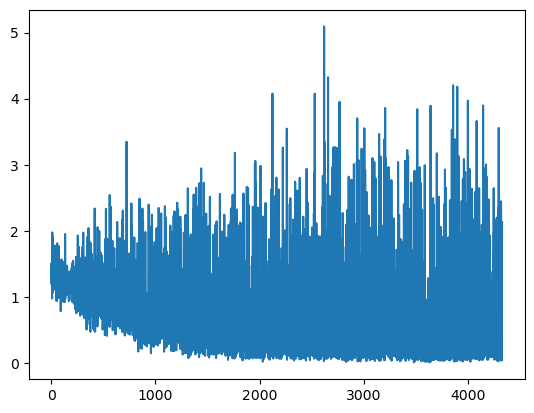

In [15]:
plt.plot(train_losses)

In [16]:
pre_label = np.empty(0)
true_label = np.empty(0)
network.eval()
for batch_idx, (data, target) in enumerate(train_loader):
    true_label = np.append(true_label, target)
    data = data.cuda()
    target.cuda()
    out = network(data)
    pre_label = np.append(pre_label, np.exp(out.cpu().detach().numpy()).argmax(axis = 1))
from sklearn.metrics import confusion_matrix
confusion_matrix(true_label, pre_label)

array([[35,  0,  0,  0],
       [ 0, 17,  0,  0],
       [ 0,  0, 61,  0],
       [ 0,  0,  0, 40]], dtype=int64)

In [17]:
pre_label = np.empty(0)
true_label = np.empty(0)
network.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    true_label = np.append(true_label, target)
    data = data.cuda()
    target.cuda()
    out = network(data)
    pre_label = np.append(pre_label, np.exp(out.cpu().detach().numpy()).argmax(axis = 1))
from sklearn.metrics import confusion_matrix
confusion_matrix(true_label, pre_label)

array([[ 7,  0,  1,  1],
       [ 0,  0,  3,  2],
       [ 1,  1, 11,  3],
       [ 5,  0,  0,  5]], dtype=int64)

# Loop through 5 folds

In [ ]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)#,
                    #   momentum=momentum)
network.cuda()
df_all = pd.DataFrame()
for i_fold in range(5):
    train_loader, test_loader = dataloader_Frogs_CV(fold_idx=i_fold, batch_size_train = 15, batch_size_test = 15, random_seed = 1842)

    network.cuda()
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    
    n_epochs = 200
    network.cuda()
    learning_rate = 0.005
    for epoch in range(1, n_epochs + 1):
        train(epoch)

    n_epochs = 1500
    network.cuda()
    learning_rate = 0.001
    for epoch in range(1, n_epochs + 1):
        train(epoch)

    pre_label = np.empty(0)
    true_label = np.empty(0)
    network.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        true_label = np.append(true_label, target)
        data = data.cuda()
        target.cuda()
        out = network(data)
        pre_label = np.append(pre_label, np.exp(out.cpu().detach().numpy()).argmax(axis = 1))

    df_fit = pd.DataFrame(data={"fold":i_fold,"type":"train","true":true_label,"predict":pre_label})

    pre_label = np.empty(0)
    true_label = np.empty(0)
    network.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        true_label = np.append(true_label, target)
        data = data.cuda()
        target.cuda()
        out = network(data)
        pre_label = np.append(pre_label, np.exp(out.cpu().detach().numpy()).argmax(axis = 1))
    from sklearn.metrics import confusion_matrix
    confusion_matrix(true_label, pre_label)
    df_test = pd.DataFrame(data={"fold":i_fold,"type":"test","true":true_label,"predict":pre_label})
    df_fold = pd.concat([df_fit, df_test])
    df_all = pd.concat([df_all, df_fold])
    df_all = df_all.reset_index(drop=True)
    network.apply(weight_reset)
df_all.to_csv("Frogs_Fewer_CV_res.csv")

# Result Summary

In [ ]:
import numpy as np
from typing import List
import os
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
df_res = pd.read_csv("Frogs_Fewer_CV_res.csv", index_col=0)
df_res.head()

In [ ]:
confusion_matrix(df_res.loc[df_res['type']=="train",'true'], df_res.loc[df_res['type']=="train",'predict'])

In [ ]:
df_res.loc[df_res['type']=="test",'true'].shape

In [ ]:
confusion_matrix(df_res.loc[df_res['type']=="test",'true'], df_res.loc[df_res['type']=="test",'predict'])

In [ ]:
for ifold in range(5):
    print(accuracy_score(df_res.loc[df_res['fold']==ifold].loc[df_res['type']=="test",'true'], df_res.loc[df_res['fold']==ifold].loc[df_res['type']=="test",'predict']))

In [ ]:
accuracy_score(df_res.loc[df_res['type']=="test",'true'], df_res.loc[df_res['type']=="test",'predict'])